# <center> Réseau avec des couches cachées </center>

**Source :** Aurélien Vannieuwenhuyze, Intelligence artificielle vulgarisée, le Machine Learning et le Deep Learning par la pratique, ENI, Paris, 2019, p.326-337.

## Importations

In [90]:
import pandas as pd
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt

## Données

In [75]:
df = pd.read_csv("df_sonar.csv")

In [76]:
# X (valeurs)
X = df[df.columns[:-1]].values
# y (labels)
y = df[df.columns[-1]]

## Encodage des labels

Les mines sont égales à 0 et les rochers égaux à 1.

In [77]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [78]:
#On ajoute un encodage pour créer des classes
# Si c'est une mine [1, 0]
# Si c'est un rocher [0, 1]
n_labels = len(y)
n_unique_labels = len(np.unique(y))
one_hot_encode = np.zeros((n_labels, n_unique_labels))
one_hot_encode[np.arange(n_labels), y] = 1
Y = one_hot_encode

In [79]:
#Vérification en prenant les enregistrements 0 et 97
print( "Classe Rocher: ", int(Y[0][1]))
print( "Classe Mine :", int(Y[97][1]))

Classe Rocher:  1
Classe Mine : 0


## Création des jeux d'apprentissage et de tests

**Condition :** 192 observations d'apprentissage et 16 observations de tests (soit 0,07 %).

In [80]:
#On mélange les observations
from sklearn.utils import shuffle
X, Y = shuffle(X , Y, random_state=1)

In [81]:
#Création des jeux d'apprentissage et de tests
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.07, random_state=42)

## Paramétrage du réseau de neurones avec une couche cachée de 24 neurones

Vient ensuite la phase de paramétrage du réseau de neurones, avec la création de tuples `poids` et `poids_biais` pour le paramétrage des différents poids et biais des couches d'entrée, de la couche cachée et de la couche de sortie.

Voici le nombre de neurones utilisés pour chaque couche :
- Nombre de neurones présents dans la couche d'entrée : 60
- Nombre de neurones présents dans la couche cachée : 24
- Nombre de neurones en sortie : 2

À noter que les valeurs des poids sont générées dans l'intervalle [-0.3, 0.3] comme préconise l'étude. Cette génération est réalisée grâce à la fonction `tf.random.uniform`. Cette fonction prend également en paramètre une liste définissant le nombre de neurones de la couche d'entrée et le nombre de neurones de la couche de sortie. Ainsi [60,24] signifie qu'il faut générer des poids pour 60 neurones connectés à 24 neurones, soit un total de 1440 poids (60*24)!

In [82]:
epochs = 300

nombre_neurones_entree = 60
nombre_neurones_sortie = 2
nombre_neurones_couche_cachee = 24

taux_apprentissage = 0.01

In [83]:
#Variable TensorFLow correspondant aux 60 valeurs des neurones d'entrée
tf_neurones_entrees_X = tf.placeholder(tf.float32, [None, 60])

#Variable TensorFlow correspondant aux 2 neurones de sortie
tf_valeurs_reelles_Y = tf.placeholder(tf.float32, [None, 2])

In [84]:
poids = {
    # 60 neurones d'entrées vers 24 Neurones de la couche cachée
    'couche_entree_vers_cachee': tf.Variable(tf.random_uniform([60, 24], minval=-0.3, maxval=0.3), tf.float32),

    # 24 neurones de la couche cachée vers 2 de la couche de sortie
    'couche_cachee_vers_sortie': tf.Variable(tf.random_uniform([24, 2], minval=-0.3, maxval=0.3), tf.float32),
}

poids_biais = {
     #1 biais de la couche d'entrée vers les 24 neurones de la couche cachée
    'poids_biais_couche_entree_vers_cachee': tf.Variable(tf.zeros([24]), tf.float32),

    #1 biais de la couche cachée vers les 2 neurones de la couche de sortie
    'poids_biais_couche_cachee_vers_sortie': tf.Variable(tf.zeros([2]), tf.float32),
}

Nous définissons ensuite une fonction chargée de créer le réseau de neurones.
On y retrouve la définition des différentes fonctions d'activation de type sigmoïde
de chaque couche en veillant à bien utiliser les poids adéquats en relation
avec la couche concernée. 

Cette fonction nous retourne le modèle que l'on
pourra utiliser par la suite dans la phase de test afin de vérifier le bon apprentissage
du réseau de neurones.

In [85]:
def reseau_neurones_multicouches(observations_en_entrees, poids, poids_biais):

    #Calcul de l'activation de la première couche
    premiere_activation = tf.sigmoid(tf.matmul(tf_neurones_entrees_X, poids['couche_entree_vers_cachee']) + poids_biais['poids_biais_couche_entree_vers_cachee'])

    #Calcul de l'activation de la seconde couche
    activation_couche_cachee = tf.sigmoid(tf.matmul(premiere_activation, poids['couche_cachee_vers_sortie']) + poids_biais['poids_biais_couche_cachee_vers_sortie'])

    return activation_couche_cachee

### Création du réseau de neurones

In [86]:
reseau = reseau_neurones_multicouches(tf_neurones_entrees_X, poids, poids_biais)

### Fonction d'erreur et fonction d'optimisation

In [87]:
#Fonction d'erreur de moyenne quadratique MSE
fonction_erreur = tf.reduce_sum(tf.pow(tf_valeurs_reelles_Y-reseau,2))

#Descente de gradient avec un taux d'apprentissage fixé à 0.1
optimiseur = tf.train.GradientDescentOptimizer(learning_rate=taux_apprentissage).minimize(fonction_erreur)

## Apprentissage

In [88]:
#Initialisation des variable
init = tf.global_variables_initializer()

#Démarrage d'une session d'apprentissage
session = tf.Session()
session.run(init)

#Pour la réalisation du graphique pour la MSE
Graphique_MSE=[]


#Pour chaque epoch
for i in range(epochs):

   #Realisation de l'apprentissage avec mise à jour des poids
   session.run(optimiseur, feed_dict = {tf_neurones_entrees_X: train_x, tf_valeurs_reelles_Y:train_y})

   #Calculer l'erreur
   MSE = session.run(fonction_erreur, feed_dict = {tf_neurones_entrees_X: train_x, tf_valeurs_reelles_Y:train_y})

   #Affichage des informations
   Graphique_MSE.append(MSE)
   print("EPOCH (" + str(i) + "/" + str(epochs) + ") -  MSE: "+ str(MSE))

EPOCH (0/300) -  MSE: 97.58148
EPOCH (1/300) -  MSE: 96.026024
EPOCH (2/300) -  MSE: 95.52481
EPOCH (3/300) -  MSE: 95.049934
EPOCH (4/300) -  MSE: 94.756996
EPOCH (5/300) -  MSE: 94.47017
EPOCH (6/300) -  MSE: 94.239235
EPOCH (7/300) -  MSE: 94.009224
EPOCH (8/300) -  MSE: 93.797806
EPOCH (9/300) -  MSE: 93.58394
EPOCH (10/300) -  MSE: 93.37436
EPOCH (11/300) -  MSE: 93.15987
EPOCH (12/300) -  MSE: 92.943146
EPOCH (13/300) -  MSE: 92.71969
EPOCH (14/300) -  MSE: 92.490585
EPOCH (15/300) -  MSE: 92.25336
EPOCH (16/300) -  MSE: 92.00842
EPOCH (17/300) -  MSE: 91.7543
EPOCH (18/300) -  MSE: 91.49114
EPOCH (19/300) -  MSE: 91.21797
EPOCH (20/300) -  MSE: 90.93486
EPOCH (21/300) -  MSE: 90.641174
EPOCH (22/300) -  MSE: 90.33697
EPOCH (23/300) -  MSE: 90.02184
EPOCH (24/300) -  MSE: 89.69592
EPOCH (25/300) -  MSE: 89.35902
EPOCH (26/300) -  MSE: 89.01139
EPOCH (27/300) -  MSE: 88.65304
EPOCH (28/300) -  MSE: 88.28444
EPOCH (29/300) -  MSE: 87.90586
EPOCH (30/300) -  MSE: 87.518234
EPOCH (31

EPOCH (289/300) -  MSE: 52.008762
EPOCH (290/300) -  MSE: 53.130768
EPOCH (291/300) -  MSE: 51.91781
EPOCH (292/300) -  MSE: 53.036385
EPOCH (293/300) -  MSE: 51.827904
EPOCH (294/300) -  MSE: 52.943184
EPOCH (295/300) -  MSE: 51.739044
EPOCH (296/300) -  MSE: 52.851143
EPOCH (297/300) -  MSE: 51.651196
EPOCH (298/300) -  MSE: 52.76025
EPOCH (299/300) -  MSE: 51.56434


## Visualisation

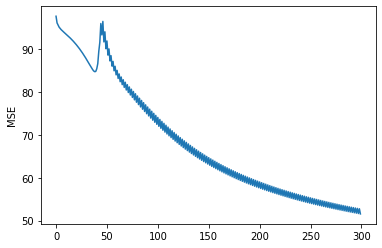

In [91]:
#Affichage graphique

plt.plot(Graphique_MSE)
plt.ylabel('MSE')
plt.show()

## Vérification de l'apprentissage

Les probabilités de chaque classe 'Mine' ou 'rocher' issues de l'apprentissage sont stockée dans le modèle.

A l'aide de `tf.argmax`, on récupére les indexs des probabilités les plus elevées pour chaque observations.

**Ex :** Si pour une observation nous avons **[0.56, 0.89]** renverra **1** car la valeur la plus élevée se trouve à l'index **1**.

**Ex :** Si pour une observation nous avons **[0.90, 0.34 ]**  renverra **0** car la valeur la plus élevée se trouve à l'index **0**.

In [92]:
classifications = tf.argmax(reseau, 1)

In [94]:
'''Dans le tableau des valeurs réelles :
Les mines sont encodées comme suit [1,0] l'index ayant la plus grande valeur est 0
Les rochers ont pour valeur [0,1] sl'index ayant la plus grande valeur est 1.

Si la classification est de [0.90, 0.34 ] l'index ayant la plus grande valeur est 0
Si c'est une mine [1,0] l'index ayant la plus grande valeur est 0.
Si les deux index sont identiques alors on peut affirmer que c'est une bonne classification'''
formule_calcul_bonnes_classifications = tf.equal(classifications, tf.argmax(tf_valeurs_reelles_Y,1))


#La précision se calcul en faisant la moyenne (tf.mean)
# des bonnes classifications (après les avoir converties en décimale tf.cast, tf.float32)
formule_precision = tf.reduce_mean(tf.cast(formule_calcul_bonnes_classifications, tf.float32))

## Précision sur les données de test

In [95]:
nb_classifications = 0;
nb_bonnes_classifications = 0

#On parcours l'ensemble des données de test (text_x)
for i in range(0,test_x.shape[0]):

    #On récupere les informations
    donneesSonar = test_x[i].reshape(1,60)
    classificationAttendue = test_y[i].reshape(1,2)

    # On réalise la classification
    prediction_run = session.run(classifications, feed_dict={tf_neurones_entrees_X:donneesSonar})

    #On calcule la précision de la classification à l'aide de la formule établie auparavant
    accuracy_run = session.run(formule_precision, feed_dict={tf_neurones_entrees_X:donneesSonar, tf_valeurs_reelles_Y:classificationAttendue})


    #On affiche pour observation la classe originale et la classification réalisée
    print(i,"Classe attendue: ", int(session.run(tf_valeurs_reelles_Y[i][1],feed_dict={tf_valeurs_reelles_Y:test_y})), " Classification: ", prediction_run[0] )

    nb_classifications = nb_classifications+1
    if(accuracy_run*100 ==100):
        nb_bonnes_classifications = nb_bonnes_classifications+1


print("-------------")
print("Précision sur les donnees de tests = "+str((nb_bonnes_classifications/nb_classifications)*100)+"%")

0 Classe attendue:  1  Classification:  1
1 Classe attendue:  0  Classification:  0
2 Classe attendue:  1  Classification:  1
3 Classe attendue:  1  Classification:  1
4 Classe attendue:  0  Classification:  0
5 Classe attendue:  1  Classification:  1
6 Classe attendue:  0  Classification:  0
7 Classe attendue:  1  Classification:  1
8 Classe attendue:  1  Classification:  1
9 Classe attendue:  0  Classification:  0
10 Classe attendue:  0  Classification:  0
11 Classe attendue:  0  Classification:  0
12 Classe attendue:  0  Classification:  0
13 Classe attendue:  0  Classification:  0
14 Classe attendue:  0  Classification:  1
-------------
Précision sur les donnees de tests = 93.33333333333333%


## Précision sur les données d'apprentissage

Permet de vérifier si nous ne sommes pas en situation d'*overfitting*.

In [98]:
nb_classifications = 0;
nb_bonnes_classifications = 0
for i in range(0,train_x.shape[0]):

    # On récupere les informations
    donneesSonar = train_x[i].reshape(1, 60)
    classificationAttendue = train_y[i].reshape(1, 2)

    # On réalise la classification
    prediction_run = session.run(classifications, feed_dict={tf_neurones_entrees_X: donneesSonar})

    # On calcule la précision de la classification à l'aide de la formule établie auparavant
    accuracy_run = session.run(formule_precision, feed_dict={tf_neurones_entrees_X: donneesSonar, tf_valeurs_reelles_Y: classificationAttendue})

    nb_classifications = nb_classifications + 1
    if (accuracy_run * 100 == 100):
        nb_bonnes_classifications = nb_bonnes_classifications + 1


print("Précision sur les donnees d'apprentissage = " + str((nb_bonnes_classifications / nb_classifications) * 100) + "%")

Précision sur les donnees d'apprentissage = 80.20833333333334%


## Précision sur l'ensemble des données

In [99]:
nb_classifications = 0;
nb_bonnes_classifications = 0
for i in range(0,207):

    prediction_run = session.run(classifications, feed_dict={tf_neurones_entrees_X:X[i].reshape(1,60)})
    accuracy_run = session.run(formule_precision, feed_dict={tf_neurones_entrees_X:X[i].reshape(1,60), tf_valeurs_reelles_Y:Y[i].reshape(1,2)})

    nb_classifications = nb_classifications + 1
    if (accuracy_run * 100 == 100):
        nb_bonnes_classifications = nb_bonnes_classifications + 1


print("Précision sur l'ensemble des données = " + str((nb_bonnes_classifications / nb_classifications) * 100) + "%")




session.close()

Précision sur l'ensemble des données = 81.15942028985508%


Comme il n'y a pas d'écart important entre la précision obtenue lors de l'apprentissage
et la validation, nous ne sommes pas dans un cas de surapprentissage.

---

## Avec 12 neurones au lieu de 24

---

### Modification des poids

In [100]:
poids = {
    # 60 neurones d'entrées vers 24 Neurones de la couche cachée
    'couche_entree_vers_cachee': tf.Variable(tf.random_uniform([60, 12], minval=-0.3, maxval=0.3), tf.float32),

    # 12 neurones de la couche cachée vers 2 de la couche de sortie
    'couche_cachee_vers_sortie': tf.Variable(tf.random_uniform([12, 2], minval=-0.3, maxval=0.3), tf.float32),


}

poids_biais = {
     #1 biais de la couche d'entrée vers les 24 neurones de la couche cachée
    'poids_biais_couche_entree_vers_cachee': tf.Variable(tf.zeros([12]), tf.float32),

    #1 biais de la couche cachée vers les 2 neurones de la couche de sortie
    'poids_biais_couche_cachee_vers_sortie': tf.Variable(tf.zeros([2]), tf.float32),
}

### Création du réseau

In [101]:
def reseau_neurones_multicouches(observations_en_entrees, poids, poids_biais):

    #Calcul de l'activation de la première couche
    premiere_activation = tf.sigmoid(tf.matmul(tf_neurones_entrees_X, poids['couche_entree_vers_cachee']) + poids_biais['poids_biais_couche_entree_vers_cachee'])

    #Calcul de l'activation de la seconde couche
    activation_couche_cachee = tf.sigmoid(tf.matmul(premiere_activation, poids['couche_cachee_vers_sortie']) + poids_biais['poids_biais_couche_cachee_vers_sortie'])

    return activation_couche_cachee

In [102]:
reseau = reseau_neurones_multicouches(tf_neurones_entrees_X, poids, poids_biais)

### Fonction d'erreur et fonction d'optimisation

In [104]:
#Fonction d'erreur de moyenne quadratique MSE
fonction_erreur = tf.reduce_sum(tf.pow(tf_valeurs_reelles_Y-reseau,2))

#Fonction de precision
fonction_precision = tf.metrics.accuracy(labels=tf_valeurs_reelles_Y,predictions=reseau)

#Descente de gradient avec un taux d'apprentissage fixé à 0.1
optimiseur = tf.train.GradientDescentOptimizer(learning_rate=taux_apprentissage).minimize(fonction_erreur)

### Apprentissage

In [105]:
#Initialisation des variable
init = tf.global_variables_initializer()

#Demarrage d'une session d'apprentissage
session = tf.Session()
session.run(init)

#Pour la réalisation du graphique pour la MSE
Graphique_MSE=[]


#Pour chaque epoch
for i in range(epochs):

   #Realisation de l'apprentissage avec mise à jour des poids
   session.run(optimiseur, feed_dict = {tf_neurones_entrees_X: train_x, tf_valeurs_reelles_Y:train_y})

   #Calculer l'erreur d'apprentissage
   MSE = session.run(fonction_erreur, feed_dict = {tf_neurones_entrees_X: train_x, tf_valeurs_reelles_Y:train_y})

   #Affichage des informations
   Graphique_MSE.append(MSE)
   print("EPOCH (" + str(i) + "/" + str(epochs) + ") -  MSE: "+ str(MSE))

EPOCH (0/300) -  MSE: 96.20565
EPOCH (1/300) -  MSE: 96.111404
EPOCH (2/300) -  MSE: 96.02077
EPOCH (3/300) -  MSE: 95.93288
EPOCH (4/300) -  MSE: 95.84723
EPOCH (5/300) -  MSE: 95.76337
EPOCH (6/300) -  MSE: 95.68086
EPOCH (7/300) -  MSE: 95.59928
EPOCH (8/300) -  MSE: 95.51822
EPOCH (9/300) -  MSE: 95.43729
EPOCH (10/300) -  MSE: 95.35607
EPOCH (11/300) -  MSE: 95.2742
EPOCH (12/300) -  MSE: 95.19131
EPOCH (13/300) -  MSE: 95.10701
EPOCH (14/300) -  MSE: 95.02095
EPOCH (15/300) -  MSE: 94.93273
EPOCH (16/300) -  MSE: 94.841995
EPOCH (17/300) -  MSE: 94.74841
EPOCH (18/300) -  MSE: 94.65157
EPOCH (19/300) -  MSE: 94.55112
EPOCH (20/300) -  MSE: 94.446686
EPOCH (21/300) -  MSE: 94.3379
EPOCH (22/300) -  MSE: 94.224365
EPOCH (23/300) -  MSE: 94.10573
EPOCH (24/300) -  MSE: 93.98158
EPOCH (25/300) -  MSE: 93.85158
EPOCH (26/300) -  MSE: 93.71532
EPOCH (27/300) -  MSE: 93.5724
EPOCH (28/300) -  MSE: 93.42247
EPOCH (29/300) -  MSE: 93.26514
EPOCH (30/300) -  MSE: 93.10001
EPOCH (31/300) - 

EPOCH (273/300) -  MSE: 54.0468
EPOCH (274/300) -  MSE: 52.642708
EPOCH (275/300) -  MSE: 53.931313
EPOCH (276/300) -  MSE: 52.534817
EPOCH (277/300) -  MSE: 53.817566
EPOCH (278/300) -  MSE: 52.428406
EPOCH (279/300) -  MSE: 53.70553
EPOCH (280/300) -  MSE: 52.323433
EPOCH (281/300) -  MSE: 53.595165
EPOCH (282/300) -  MSE: 52.21987
EPOCH (283/300) -  MSE: 53.486443
EPOCH (284/300) -  MSE: 52.117687
EPOCH (285/300) -  MSE: 53.379337
EPOCH (286/300) -  MSE: 52.01685
EPOCH (287/300) -  MSE: 53.273827
EPOCH (288/300) -  MSE: 51.917328
EPOCH (289/300) -  MSE: 53.16987
EPOCH (290/300) -  MSE: 51.819088
EPOCH (291/300) -  MSE: 53.06744
EPOCH (292/300) -  MSE: 51.7221
EPOCH (293/300) -  MSE: 52.966515
EPOCH (294/300) -  MSE: 51.626328
EPOCH (295/300) -  MSE: 52.86707
EPOCH (296/300) -  MSE: 51.531754
EPOCH (297/300) -  MSE: 52.769066
EPOCH (298/300) -  MSE: 51.438354
EPOCH (299/300) -  MSE: 52.672493


### Visualisation

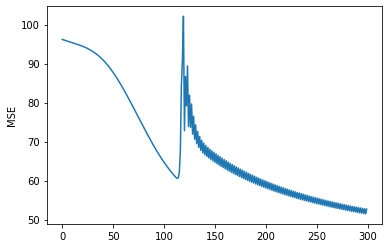

In [106]:
#Affichage graphique MSE
plt.plot(Graphique_MSE)
plt.ylabel('MSE')
plt.show()

### Vérification de l'apprentissage

In [107]:
classifications = tf.argmax(reseau, 1)
formule_calcul_bonnes_classifications = tf.equal(classifications, tf.argmax(tf_valeurs_reelles_Y,1))
formule_precision = tf.reduce_mean(tf.cast(formule_calcul_bonnes_classifications, tf.float32))

### Précision sur les données de test

In [108]:
nb_classifications = 0;
nb_bonnes_classifications = 0

#On parcours l'ensemble des données de test (text_x)
for i in range(0,test_x.shape[0]):

    #On récupere les informations
    donneesSonar = test_x[i].reshape(1,60)
    classificationAttendue = test_y[i].reshape(1,2)

    # On réalise la classification
    prediction_run = session.run(classifications, feed_dict={tf_neurones_entrees_X:donneesSonar})

    #On calcule la précision de la classification à l'aide de la formule établie auparavant
    accuracy_run = session.run(formule_precision, feed_dict={tf_neurones_entrees_X:donneesSonar, tf_valeurs_reelles_Y:classificationAttendue})


    #On affiche pour observation la classe originale et la classification réalisée
    print(i,"Classe attendue: ", int(session.run(tf_valeurs_reelles_Y[i][1],feed_dict={tf_valeurs_reelles_Y:test_y})), " Classification: ", prediction_run[0] )

    nb_classifications = nb_classifications+1
    if(accuracy_run*100 ==100):
        nb_bonnes_classifications = nb_bonnes_classifications+1


print("-------------")
print("Précision sur les donnees de tests = "+str((nb_bonnes_classifications/nb_classifications)*100)+"%")

0 Classe attendue:  1  Classification:  1
1 Classe attendue:  0  Classification:  0
2 Classe attendue:  1  Classification:  1
3 Classe attendue:  1  Classification:  0
4 Classe attendue:  0  Classification:  0
5 Classe attendue:  1  Classification:  1
6 Classe attendue:  0  Classification:  0
7 Classe attendue:  1  Classification:  0
8 Classe attendue:  1  Classification:  0
9 Classe attendue:  0  Classification:  0
10 Classe attendue:  0  Classification:  0
11 Classe attendue:  0  Classification:  0
12 Classe attendue:  0  Classification:  0
13 Classe attendue:  0  Classification:  0
14 Classe attendue:  0  Classification:  0
-------------
Précision sur les donnees de tests = 80.0%


### Précision sur les données d'apprentissage

In [109]:
nb_classifications = 0;
nb_bonnes_classifications = 0
for i in range(0,train_x.shape[0]):

    # On récupere les informations
    donneesSonar = train_x[i].reshape(1, 60)
    classificationAttendue = train_y[i].reshape(1, 2)

    # On réalise la classification
    prediction_run = session.run(classifications, feed_dict={tf_neurones_entrees_X: donneesSonar})

    # On calcule la précision de la classification à l'aide de la formule établie auparavant
    accuracy_run = session.run(formule_precision, feed_dict={tf_neurones_entrees_X: donneesSonar, tf_valeurs_reelles_Y: classificationAttendue})

    nb_classifications = nb_classifications + 1
    if (accuracy_run * 100 == 100):
        nb_bonnes_classifications = nb_bonnes_classifications + 1


print("Précision sur les donnees d'apprentissage = " + str((nb_bonnes_classifications / nb_classifications) * 100) + "%")

Précision sur les donnees d'apprentissage = 80.72916666666666%


### Précision sur l'ensemble des données

In [110]:
nb_classifications = 0;
nb_bonnes_classifications = 0
for i in range(0,207):

    prediction_run = session.run(classifications, feed_dict={tf_neurones_entrees_X:X[i].reshape(1,60)})
    accuracy_run = session.run(formule_precision, feed_dict={tf_neurones_entrees_X:X[i].reshape(1,60), tf_valeurs_reelles_Y:Y[i].reshape(1,2)})

    nb_classifications = nb_classifications + 1
    if (accuracy_run * 100 == 100):
        nb_bonnes_classifications = nb_bonnes_classifications + 1


print("Précision sur l'ensemble des données = " + str((nb_bonnes_classifications / nb_classifications) * 100) + "%")

Précision sur l'ensemble des données = 80.67632850241546%


### Fermeture de la session tf

In [111]:
session.close()

---